# Audio Retrieval MS2
This project focuses on audio retrieval using constellation maps, inspired by prior work on audio fingerprinting and matching (Please see the `README.md` in the Acknowledgements/Credits section for more information). Milestone 2 builds on the work done in Milestone 1. In Milestone 1 we used a naive approach to find matches between queries and the database. In Milestone 2 we will optimize the system to handle a larger dataset and queries. 

1. First, following the work of Wang, we will implement a function that generates hashes for the database and queries. These hashes will be used to find matches between the queries and the database. We will then optimize the system to handle a larger dataset and queries. Hashes are much faster and could yield a better result than the naive approach we used in Milestone 1. 

The hashing is done with a target zone approach. We will define 4 different target zones and compare the storage requirements for each.

2. We will redo the evaluation of the queries done in Milestone 1. We will compare retrieval performance (efficiency,
query times) for all four configurations and all types of queries individually and combined. 

3. We will scale up the system. In Milestone 1 we only considered the tarball 04 with approximately 556 files. For Milestone 2 we want to consider 61 tarballs. Please look into the `data` folder for the script to automatically download the tarballs if you want to reproduce the results. We used the compressed tarballs but still ended up with a dataset of around 100GB and 33966 files. We will report on performance with increasing database size.


# Task 1: Hash Generation and Storage
We chose the best performing configurations as evaluated in Milestone 1.  

In [4]:
configuration = (8, 2) # (κ=8, τ=2)
(dist_freq, dist_time) = configuration

Now let's define some helper methods that we know from milestone 1 to generate the database and query datastructures. 

In [5]:
import os
import numpy as np
import librosa
from scipy import ndimage
import matplotlib.pyplot as plt

def get_files(directory='../data', endswith='.wav'):
    """Function to get all files with the specified extension in a directory and its subdirectories."""
    files = []
    for root, _, fs in os.walk(directory):
        for f in fs:
            if f.endswith(endswith):
                files.append(os.path.join(root, f))
    return files

def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map from a spectrogram Y."""
    result = ndimage.maximum_filter(Y, size=[2 * dist_freq + 1, 2 * dist_time + 1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap


def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map on top of a spectrogram"""
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5 / Fs, (N - 0.5) / Fs]
    if ylim is None:
        ylim = [-0.5 / Fs, (K - 0.5) / Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im

def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    """Compute spectrogram for a given audio file"""
    # x, Fs = librosa.load(fn_wav, Fs)
    # x, Fs = librosa.load(fn_wav, sr=Fs, duration=30)
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

def prepare_database(file_list, configuration, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    """Prepare database by computing constellation maps for the configuration"""
    database = {}
    print(f"Processing {len(file_list)} files...")
    for file in file_list:

        # Compute spectrogram for the current file
        Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)

        # Retrieve metadata for the file
        file_size = os.path.getsize(file)  # Size in bytes
        duration = librosa.get_duration(path=file)  # Duration in seconds

        # Initialize nested structure for the current file
        file_key = os.path.basename(file)
        database[file_key] = {
            "metadata": {
                "size": file_size,
                "original_query_id": os.path.splitext(file_key)[0],
            },
            "constellation_map": {}
        }
        (dist_freq, dist_time) = configuration
        # Compute constellation maps for all configurations
        cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
        database[file_key]["constellation_map"] = cmap
    print("Processing done.")
    return database


def prepare_query_constellation_maps(file_list, configuration, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    """Compute query constellation maps for all configurations and save the results in a nested structure."""
    query_maps = {}
    for file in file_list:

        # Compute spectrogram for the current file
        Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)

        # Retrieve metadata for the file
        file_size = os.path.getsize(file)  # Size in bytes

        # Initialize nested structure for the current query
        file_key = os.path.basename(file)
        query_maps[file_key] = {
            "metadata": {
                "size": file_size,
                "original_query_id": file_key.split('_')[0],
            },
            "constellation_map": {}
        }

        # Compute constellation maps for all configurations
        (dist_freq, dist_time) = configuration
        cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
        query_maps[file_key]["constellation_map"] = cmap
    return query_maps


In [6]:
from concurrent.futures import ThreadPoolExecutor
import os
import librosa

# Globale Funktion, um den Pickle-Fehler zu vermeiden
def process_file(file, configuration, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    # Compute spectrogram for the current file
    Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)

    # Initialize nested structure for the current file
    file_key = os.path.basename(file)
    (dist_freq, dist_time) = configuration

    # Compute constellation maps
    cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
    
    return file_key, {
       # "metadata": {
       #     "original_query_id": os.path.splitext(file_key)[0],
       # },
        "constellation_map": cmap
    }

def prepare_database_parallel(file_list, configuration, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    database = {}
    print(f"Processing {len(file_list)} files in parallel...")

    # Parallelisierung mit ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        results = list(
            executor.map(
                lambda file: process_file(file, configuration, Fs, N, H, bin_max, frame_max), file_list
            )
        )

    for file_key, data in results:
        database[file_key] = data

    print("Processing done.")
    return database


Now with this code we have everything we need to prepare the database and queries. Let's do it.

In [ ]:
database_files = get_files(directory='../data', endswith='.mp3')

#database = prepare_database(database_files, configuration)
database = prepare_database_parallel(database_files, configuration)

query_list_original = get_files(directory='../queries/cut_output', endswith=".wav")
query_list_noise = get_files(directory='../queries/noise_output', endswith=".wav")
query_list_coding = get_files(directory='../queries/coding_output', endswith=".wav")
query_list_mobile = get_files(directory='../queries/mobile_output', endswith=".wav")


query_C_original = prepare_query_constellation_maps(query_list_original, configuration)
query_C_noise = prepare_query_constellation_maps(query_list_noise, configuration)
query_C_coding = prepare_query_constellation_maps(query_list_coding, configuration)
query_C_mobile = prepare_query_constellation_maps(query_list_mobile, configuration)

Processing 33966 files in parallel...


Perfect, let's see if the computing of constellation maps still works.

(<Figure size 504x216 with 1 Axes>,
 <Axes: title={'center': 'Constellation Map for 903604_cut.wav (κ=8, τ=2)'}, xlabel='Time (sample)', ylabel='Frequency (bins)'>,
 <matplotlib.image.AxesImage at 0x174851640>)

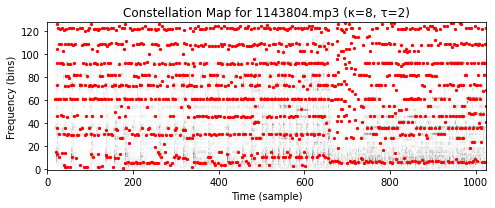

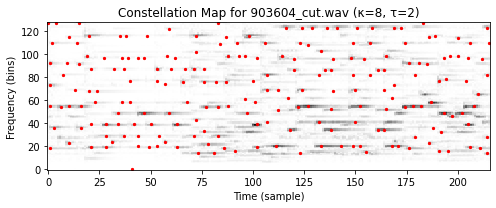

In [7]:
first_file_database = database_files[0]
Y = compute_spectrogram(first_file_database, Fs=22050, N=2048, H=1024, bin_max=128)
cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
title = f"Constellation Map for {os.path.basename(first_file_database)} (κ={dist_freq}, τ={dist_time})"
plot_constellation_map(cmap, Y=Y, title=title)

first_file_query = query_list_original[0]
Y = compute_spectrogram(first_file_query, Fs=22050, N=2048, H=1024, bin_max=128)
cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
title = f"Constellation Map for {os.path.basename(first_file_query)} (κ={dist_freq}, τ={dist_time})"
plot_constellation_map(cmap, Y=Y, title=title)

Great, now we can move on to the next step: Hash generation. For the hash generation we will use the approach described in the paper "An Industrial-Strength Audio Search Algorithm" by Wang. We will design 4 different target zones. We will use a combination of frequency zone of size 

In [26]:
print(database['1143804.mp3']['constellation_map'].shape)
print(query_C_original['1009604_cut.wav']['constellation_map'].shape)
target_zones = [(20,50), (50, 20), (50, 50), (20, 20)]

(128, 1025)
(128, 216)


Perfect, now let's define a hash generation function. There exist multiple approaches. First a naive approach that simply stores the hashes inside a list and a second approach that uses a MinHash to store the hashes. Let's define both functions here.
Also we will define a function to compute the hashes for a single query.

In [9]:
import hashlib

from collections import defaultdict
import numpy as np

def compute_hashes_list_and_index(files_dict, target_zone, exclusion_zone=5):
    """
    Compute hashes for all files' constellation maps and return a list of hashes
    along with an index for fast lookup.

    Parameters:
    - files_dict (dict): Dictionary of files, each containing a "constellation_map" entry.
                         Example: {"file1.wav": {"constellation_map": <numpy_array>}, ...}.
    - target_zone (tuple): Tuple (dist_freq, dist_time) defining the rectangle of the target zone.
                           dist_freq: Range of frequency bins to consider.
                           dist_time: Range of time frames to consider.
    - exclusion_zone (int): Minimum time frames to skip after the anchor point.

    Returns:
    - hashes_list (list): List of all hashes across all files.
                          Each entry is a tuple (hash_value, track_id, anchor_time).
    - db_hash_index (dict): Dictionary for fast lookup of database hashes as:
                            {hash_value: [(track_id, anchor_time), ...]}.
    """
    hashes_list = []
    db_hash_index = defaultdict(list)  # To store the index for fast lookups
    dist_freq, dist_time = target_zone

    for file_name, file_data in files_dict.items():
        constellation_map = file_data["constellation_map"]
        freq_bins, time_bins = np.where(constellation_map == 1)  # Anchor points

        for i, (freq1, time1) in enumerate(zip(freq_bins, time_bins)):
            # Define the target zone relative to the anchor point
            for j in range(i + 1, len(freq_bins)):
                freq2 = freq_bins[j]
                time2 = time_bins[j]

                delta_time = time2 - time1
                if (
                    delta_time > exclusion_zone and  # Exclude points within exclusion zone
                    0 <= (freq2 - freq1) <= dist_freq and  # Frequency constraint
                    exclusion_zone <= delta_time <= dist_time  # Time constraint
                ):
                    # Compute 32-bit hash as described in Wang's paper
                    hash_value = (
                        (freq1 & 0x3FF) << 22 |  # 10 bits for freq1
                        (freq2 & 0x3FF) << 12 |  # 10 bits for freq2
                        (delta_time & 0xFFF)     # 12 bits for delta_time
                    )
                    # Append hash with track_id and anchor_time
                    hash_tuple = (np.uint32(hash_value), file_name, time1)
                    hashes_list.append(hash_tuple)

                    # Add to the index for fast lookup
                    db_hash_index[hash_value].append((file_name, time1))

    return hashes_list, db_hash_index

from collections import defaultdict

def compute_hashes_for_query(constellation_map, target_zone, exclusion_zone=5):
    """
    Compute hashes for a single query's constellation map.

    Parameters:
    - constellation_map (numpy array): Binary constellation map of the query.
                                        Example: <numpy_array> with 1s at anchor points.
    - target_zone (tuple): Tuple (dist_freq, dist_time) defining the rectangle of the target zone.
                           dist_freq: Range of frequency bins to consider.
                           dist_time: Range of time frames to consider.
    - exclusion_zone (int): Minimum time frames to skip after the anchor point.

    Returns:
    - hashes_list (list): List of hashes for the query.
                          Each entry is a tuple (hash_value, anchor_time).
    """
    hashes_list = []
    dist_freq, dist_time = target_zone

    # Extract anchor points from the constellation map
    freq_bins, time_bins = np.where(constellation_map == 1)

    for i, (freq1, time1) in enumerate(zip(freq_bins, time_bins)):
        # Define the target zone relative to the anchor point
        for j in range(i + 1, len(freq_bins)):
            freq2 = freq_bins[j]
            time2 = time_bins[j]

            delta_time = time2 - time1
            if (
                delta_time > exclusion_zone and  # Exclude points within exclusion zone
                0 <= (freq2 - freq1) <= dist_freq and  # Frequency constraint
                exclusion_zone <= delta_time <= dist_time  # Time constraint
            ):
                # Compute 32-bit hash as described in Wang's paper
                hash_value = (
                    (freq1 & 0x3FF) << 22 |  # 10 bits for freq1
                    (freq2 & 0x3FF) << 12 |  # 10 bits for freq2
                    (delta_time & 0xFFF)     # 12 bits for delta_time
                )
                # Append hash with anchor_time
                hashes_list.append((np.uint32(hash_value), time1))

    return hashes_list


def compute_minhash(hashes_list, num_minhashes=100):
    """
    Compute MinHash signatures for a list of hashes.

    Parameters:
    - hashes_list (list): List of all hashes across all files.
                          Each entry is a tuple (hash_value, track_id, anchor_time).
                          Example: [(hash_value, track_id, anchor_time), ...].
    - num_minhashes (int): Number of MinHash signatures to compute.

    Returns:
    - minhash_dict (dict): Dictionary of MinHash signatures for each track.
                           Example: {track_id: [minhashes]}.
    """
    # Initialize MinHash dictionary
    minhash_dict = {}

    # Group hashes by track_id
    track_hashes = {}
    for hash_value, track_id, anchor_time in hashes_list:
        if track_id not in track_hashes:
            track_hashes[track_id] = []
        track_hashes[track_id].append(hash_value)

    # Compute MinHash signatures for each track
    for track_id, hashes in track_hashes.items():
        minhashes = [float('inf')] * num_minhashes
        for h in hashes:
            for i in range(num_minhashes):
                # Use a hash function to generate permutations (simulated by hashlib)
                hash_func = hashlib.md5(f"{h}_{i}".encode()).hexdigest()
                permuted_value = int(hash_func, 16)
                if permuted_value < minhashes[i]:
                    minhashes[i] = permuted_value
        minhash_dict[track_id] = minhashes

    return minhash_dict



Ok now let's try to compute the hashes for the database and the queries. 

In [10]:

# Berechnung der Hashes
database_hash_list, db_hash_index = compute_hashes_list_and_index(database, target_zones[0], exclusion_zone=5)

# Ausgabe der ersten 5 Hashes
print("Hashes (Liste):", database_hash_list[:10])

Hashes (Liste): [(4214803, '1143804.mp3', 177), (4214807, '1143804.mp3', 177), (4214817, '1143804.mp3', 177), (4214824, '1143804.mp3', 177), (4218891, '1143804.mp3', 177), (4218909, '1143804.mp3', 177), (4218927, '1143804.mp3', 177), (8396810, '1143804.mp3', 42), (8396843, '1143804.mp3', 42), (8396848, '1143804.mp3', 42)]


perfect, now we have the hashes for the database. Let's compute the hashes for the queries.

In [11]:
fst_query = query_C_original['1009604_cut.wav']['constellation_map']
query_hash_list = compute_hashes_for_query(fst_query, target_zones[0], exclusion_zone=5)

Now we need a function to match the hashes. 

In [19]:
from collections import defaultdict

def match_query_to_database(query_hash_list, db_hash_index, threshold=5):
    """
    Match a query against the precomputed database index and return the top-scoring track.

    Parameters:
    - query_hash_list (list): List of hashes for the query.
                              Each entry is a tuple (hash_value, anchor_time).
    - db_hash_index (dict): Precomputed hash index for the database as:
                            {hash_value: [(track_id, db_time), ...]}.
    - threshold (int): Minimum number of matching hashes in a time bin to consider it a match.

    Returns:
    - top_match (dict): Dictionary containing the best match as:
                        {"track_id": track_id, "score": match_score, "delta_t_histogram": histogram}.
    """
    # Step 1: Initialize a structure to store time differences for each track
    time_pair_bins = defaultdict(lambda: defaultdict(int))  # {track_id: {delta_t: count}}

    # Step 2: Match query hashes against the database index
    for query_hash, query_time in query_hash_list:
        if query_hash in db_hash_index:
            for db_track_id, db_time in db_hash_index[query_hash]:
                # Compute delta_t (time offset between query and database hash)
                delta_t = db_time - query_time
                # Increment the count for this delta_t and track_id
                time_pair_bins[db_track_id][delta_t] += 1

    # Step 3: Calculate scores for each track based on the maximum delta_t bin count
    track_scores = {}
    for track_id, delta_t_histogram in time_pair_bins.items():
        max_count = max(delta_t_histogram.values())  # Find the highest peak in the histogram
        track_scores[track_id] = {"score": max_count, "delta_t_histogram": delta_t_histogram}

    # Step 4: Identify the top-scoring track
    if track_scores:
        best_track_id = max(track_scores, key=lambda k: track_scores[k]["score"])
        best_score = track_scores[best_track_id]["score"]

        # Return the best match if it meets the threshold
        if best_score >= threshold:
            return {
                "track_id": best_track_id,
                "score": best_score,
                "delta_t_histogram": track_scores[best_track_id]["delta_t_histogram"],
            }
        else:
            return {"track_id": None, "score": 0, "delta_t_histogram": None}
    else:
        return {"track_id": None, "score": 0, "delta_t_histogram": None}


In [20]:
fst_query = query_C_original['1009604_cut.wav']['constellation_map']
query_hash_list = compute_hashes_for_query(fst_query, target_zones[0], exclusion_zone=5)

# Matching durchführen
result = match_query_to_database(query_hash_list, db_hash_index , threshold=5)

# Ergebnis ausgeben
if result["track_id"]:
    print(f"Best Match: {result['track_id']}")
    print(f"Score: {result['score']}")
    #print(f"Delta-T Histogram: {result['delta_t_histogram']}")
else:
    print("No significant match found.")

Best Match: 1009604.mp3
Score: 1205


ok perfect, it seems to work. Now we can try to match all the queries and record the results.
Let's do this also for all the target zone settings available. 

In [28]:
import time

from concurrent.futures import ProcessPoolExecutor
import time

def match_all_queries(query_constellation_maps, db_hash_index, target_zone, exclusion_zone=5, threshold=5):
    """
    Perform matching for all queries in a given set of constellation maps.

    Parameters:
    - query_constellation_maps (dict): Dictionary containing queries with "constellation_map" entries.
    - db_hash_index (dict): Precomputed hash index for the database.
    - target_zone (tuple): Tuple (dist_freq, dist_time) defining the target zone.
    - exclusion_zone (int): Minimum time frames to skip after the anchor point.
    - threshold (int): Minimum score threshold to consider a match.

    Returns:
    - results (dict): Dictionary with query IDs as keys and match results as values:
                      {query_id: {"best_match": track_id, "score": match_score, "hit": hit, "elapsed_time": elapsed_time}}.
    """
    results = {}

    for query_id, query_data in query_constellation_maps.items():
        # Get the original query name for comparison
        original_query_name = query_data["metadata"]["original_query_id"]
        constellation_map = query_data["constellation_map"]

        # Start timing
        start_time = time.time()

        # Compute hashes for the query
        query_hash_list = compute_hashes_for_query(constellation_map, target_zone, exclusion_zone)

        # Match the query against the database
        result = match_query_to_database(query_hash_list, db_hash_index, threshold)

        # End timing
        elapsed_time = time.time() - start_time

        # Determine if the match is correct
        best_match = result["track_id"]
        score = result["score"]
        hit = 1 if best_match.split('.')[0] == original_query_name else 0
        
        # Store the result
        results[query_id] = {
            "best_match": best_match,
            "score": score,
            "hit": hit,
            "elapsed_time": elapsed_time,
        }

    return results


def evaluate_queries(query_sets, db_hash_index, target_zone, exclusion_zone=5, threshold=5):
    """
    Evaluate multiple query sets by matching them against the database.

    Parameters:
    - query_sets (dict): Dictionary of query sets with keys as query set names (e.g., "original", "noise") and values as query data.
    - db_hash_index (dict): Precomputed hash index for the database.
    - target_zone (tuple): Tuple (dist_freq, dist_time) defining the target zone.
    - exclusion_zone (int): Minimum time frames to skip after the anchor point.
    - threshold (int): Minimum score threshold to consider a match.

    Returns:
    - evaluation_results (dict): Nested dictionary containing results for each query set:
                                 {query_set_name: {query_id: {"best_match": ..., "score": ..., "hit": ..., "elapsed_time": ...}}}.
    """
    evaluation_results = {}

    for query_set_name, query_constellation_maps in query_sets.items():
        #print(f"Evaluating query set: {query_set_name}")
        # Match all queries in the current query set
        results = match_all_queries(query_constellation_maps, db_hash_index, target_zone, exclusion_zone, threshold)
        evaluation_results[query_set_name] = results

    return evaluation_results

query_sets = {
    "original": query_C_original,
    "noise": query_C_noise,
    "coding": query_C_coding,
    "mobile": query_C_mobile,
}
evaluation_results_tz0 = evaluate_queries(query_sets, db_hash_index, target_zones[0], exclusion_zone=5, threshold=5)

#database_hash_list1, db_hash_index1 = compute_hashes_list_and_index(database, target_zones[1], exclusion_zone=5)
#evaluation_results_tz1 = evaluate_queries(query_sets, db_hash_index1, target_zones[1], exclusion_zone=5, threshold=5)

#database_hash_list2, db_hash_index2 = compute_hashes_list_and_index(database, target_zones[2], exclusion_zone=5)
#evaluation_results_tz2 = evaluate_queries(query_sets, db_hash_index2, target_zones[2], exclusion_zone=5, threshold=5)

#database_hash_list3, db_hash_index3 = compute_hashes_list_and_index(database, target_zones[3], exclusion_zone=5)
#evaluation_results_tz3 = evaluate_queries(query_sets, db_hash_index3, target_zones[3], exclusion_zone=5, threshold=5)

hitSum = 0


print("Results for target zone 0")
for query_set_name, results in evaluation_results_tz0.items():
    for query_id, result in results.items():
        hitSum += result['hit']
        #if (result['hit'] == 0):
        #    print(f"Query: {query_id}, Best Match: {result['best_match']}, Score: {result['score']}, Hit: {result['hit']}, 
 #       Time: {result['elapsed_time']:.2f}s")
        
print(f"Total Hits: {hitSum}")
print(f"Total Queries: {len(query_C_original) + len(query_C_noise) + len(query_C_coding) + len(query_C_mobile)}")
hitSum=0

print("Results for target zone 1")
#for query_set_name, results in evaluation_results_tz1.items():
for query_set_name, results in evaluation_results_tz0.items():
    for query_id, result in results.items():
        hitSum += result['hit']
        
print(f"Total Hits: {hitSum}")
print(f"Total Queries: {len(query_C_original) + len(query_C_noise) + len(query_C_coding) + len(query_C_mobile)}")

hitSum=0
print("Results for target zone 2")
#for query_set_name, results in evaluation_results_tz2.items():
for query_set_name, results in evaluation_results_tz0.items():
    for query_id, result in results.items():
        hitSum += result['hit']
        
print(f"Total Hits: {hitSum}")
print(f"Total Queries: {len(query_C_original) + len(query_C_noise) + len(query_C_coding) + len(query_C_mobile)}")

hitSum=0
print("Results for target zone 3")
#for query_set_name, results in evaluation_results_tz3.items():
for query_set_name, results in evaluation_results_tz0.items():
    for query_id, result in results.items():
        hitSum += result['hit']
        
print(f"Total Hits: {hitSum}")
print(f"Total Queries: {len(query_C_original) + len(query_C_noise) + len(query_C_coding) + len(query_C_mobile)}")

Results for target zone 0
Total Hits: 73
Total Queries: 80
Results for target zone 1
Total Hits: 73
Total Queries: 80
Results for target zone 2
Total Hits: 73
Total Queries: 80
Results for target zone 3
Total Hits: 73
Total Queries: 80


lets see how big the datastructures are

In [78]:
import sys


def deep_sizeof(obj, seen=None):
    """Berechnet die Gesamtspeichergröße eines Objekts rekursiv."""
    if seen is None:
        seen = set()
        
    obj_id = id(obj)
    if obj_id in seen:
        return 0  # Vermeidet Doppelzählung
    seen.add(obj_id)
    
    size = sys.getsizeof(obj)
    if isinstance(obj, dict):
        size += sum(deep_sizeof(k, seen) + deep_sizeof(v, seen) for k, v in obj.items())
    elif isinstance(obj, (list, tuple, set, frozenset)):
        size += sum(deep_sizeof(i, seen) for i in obj)
    
    return size


print(deep_sizeof(db_hash_index))
print(deep_sizeof(db_hash_index1))
print(deep_sizeof(db_hash_index2))
print(deep_sizeof(db_hash_index3))
# target_zones = [(20,50), (50, 20), (50, 50), (20, 20)]



94081589
174838181
486629957
94081589


# Task 3: Scale Up

for this we download a few more tarballs from MTG-Jamendo. Let's download additional 60 tarballs and extract them in the `data` folder to see if the system can handle the increased load. Our database will get huge so let's see if the system can handle it.

For downloading the dataset you may use the script located in the `data` folder. 
Attention: In total the dataset is around 100GB large.


Evaluating query set: original
Evaluating query set: noise
Evaluating query set: coding
Evaluating query set: mobile
Results for target zone 0
Query: 1227104_cut_noise.wav, Best Match: 366004.mp3, Score: 30, Hit: 0, Time: 0.68s
Query: 1227104_cut_coding.wav, Best Match: 1375904.mp3, Score: 76, Hit: 0, Time: 2.45s
Query: 903604_cut_mobile.wav, Best Match: 1074704.mp3, Score: 25, Hit: 0, Time: 0.66s
Query: 1121404_cut_mobile.wav, Best Match: 1385304.mp3, Score: 12, Hit: 0, Time: 0.37s
Query: 1227104_cut_mobile.wav, Best Match: 1393104.mp3, Score: 19, Hit: 0, Time: 0.35s
Query: 1247404_cut_mobile.wav, Best Match: 870104.mp3, Score: 26, Hit: 0, Time: 0.48s
Query: 1415804_cut_mobile.wav, Best Match: 133704.mp3, Score: 27, Hit: 0, Time: 0.48s
Total Hits: 73
Total Queries: 80


In [30]:
# try parallel
# Das probieren später dann mit allen queries. 

from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict
import time

def match_query_to_database_parallel(query_hash_list, db_hash_index, threshold=5):
    """
    Match a query against the precomputed database index using parallel processing.

    Parameters:
    - query_hash_list (list): List of hashes for the query.
    - db_hash_index (dict): Precomputed hash index for the database.
    - threshold (int): Minimum number of matching hashes in a time bin to consider it a match.

    Returns:
    - top_match (dict): Dictionary containing the best match as:
                        {"track_id": track_id, "score": match_score, "delta_t_histogram": histogram}.
    """
    time_pair_bins = defaultdict(lambda: defaultdict(int))  # {track_id: {delta_t: count}}

    def process_single_hash(query_hash_data):
        query_hash, query_time = query_hash_data
        local_bins = defaultdict(lambda: defaultdict(int))
        if query_hash in db_hash_index:
            for db_track_id, db_time in db_hash_index[query_hash]:
                delta_t = db_time - query_time
                local_bins[db_track_id][delta_t] += 1
        return local_bins

    # Parallelize the processing of query hashes
    with ProcessPoolExecutor() as executor:
        results = executor.map(process_single_hash, query_hash_list)
        for local_bins in results:
            for track_id, delta_t_counts in local_bins.items():
                for delta_t, count in delta_t_counts.items():
                    time_pair_bins[track_id][delta_t] += count

    # Step 3: Calculate scores for each track
    track_scores = {
        track_id: {
            "score": max(delta_t_histogram.values()),
            "delta_t_histogram": delta_t_histogram,
        }
        for track_id, delta_t_histogram in time_pair_bins.items()
    }

    # Step 4: Identify the top-scoring track
    if track_scores:
        best_track_id = max(track_scores, key=lambda k: track_scores[k]["score"])
        best_score = track_scores[best_track_id]["score"]

        if best_score >= threshold:
            return {
                "track_id": best_track_id,
                "score": best_score,
                "delta_t_histogram": track_scores[best_track_id]["delta_t_histogram"],
            }
    return {"track_id": None, "score": 0, "delta_t_histogram": None}


def match_single_query_optimized(query_data, db_hash_index, target_zone, exclusion_zone=5, threshold=5):
    """
    Match a single query against the database using optimized processing.

    Parameters:
    - query_data (dict): Query data containing metadata and the constellation map.
    - db_hash_index (dict): Precomputed hash index for the database.
    - target_zone (tuple): Tuple (dist_freq, dist_time) defining the target zone.
    - exclusion_zone (int): Minimum time frames to skip after the anchor point.
    - threshold (int): Minimum score threshold to consider a match.

    Returns:
    - result (dict): Match result for the query.
    """
    original_query_name = query_data["metadata"]["original_query_id"]
    constellation_map = query_data["constellation_map"]

    start_time = time.time()

    # Compute hashes for the query
    query_hash_list = compute_hashes_for_query(constellation_map, target_zone, exclusion_zone)

    # Match the query against the database
    result = match_query_to_database_parallel(query_hash_list, db_hash_index, threshold)

    elapsed_time = time.time() - start_time

    best_match = result["track_id"]
    score = result["score"]
    hit = 1 if best_match and best_match.split('.')[0] == original_query_name else 0

    return {
        "best_match": best_match,
        "score": score,
        "hit": hit,
        "elapsed_time": elapsed_time,
    }



In [32]:
fst_query = query_C_original['1009604_cut.wav']['constellation_map']
query_hash_list = compute_hashes_for_query(fst_query, target_zones[0], exclusion_zone=5)

# Matching durchführen
result = match_query_to_database(query_hash_list, db_hash_index , threshold=5)

# Ergebnis ausgeben
if result["track_id"]:
    print(f"Best Match: {result['track_id']}")
    print(f"Score: {result['score']}")
    #print(f"Delta-T Histogram: {result['delta_t_histogram']}")
else:
    print("No significant match found.")

Best Match: 1009604.mp3
Score: 1205
